In [1]:
import os
import sys
import numpy as np
import pandas as pd
from imageio import imread
from tqdm import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

sys.path.append('../../')
from src.visualize.keypoint_visualization import draw_points, draw_points_and_skeleton

## Parse XML File(this process is only for CVAT)

In [2]:
#DATA_IDを指定(この例の場合は'demo_keypoint')
img_root = os.path.abspath('../../data/demo_keypoint/raw/images/')
anno_file_path = '../../data/demo_keypoint/raw/annotation/annotation.xml'

tree = ET.parse(anno_file_path)
root = tree.getroot()

In [3]:
kpt_dict ={
    0: "right_ankle",
    1: "right_knee",
    2: "right_hip",
    3: "left_hip",
    4: "left_knee",
    5: "left_ankle",
    6: "pelvis",
    7: "thorax",
    8: "upper_neck",
    9: "head_top",
    10: "right_wrist",
    11: "right_elbow",
    12: "right_shoulder",
    13: "left_shoulder",
    14: "left_elbow",
    15: "left_wrist"
}

def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val][0]

In [4]:
annotations = []
for img in root.iter('image'):
    for pts in img.iter('points'):
        xy = pts.attrib['points'].split(',')
        occluded = 1 if pts.attrib['occluded']=='0' else 0
        
        if 'group_id' in pts.keys():
            gid = int(pts.attrib['group_id']) - 1
        else:
            gid = 0
        annotations.append((
            os.path.join(img_root, img.attrib['name']),
            pts.attrib['label'],
            get_keys_from_value(kpt_dict, pts.attrib['label']),
            occluded,
            float(xy[0]),
            float(xy[1]),
            gid
        ))

_df = pd.DataFrame(annotations, columns=['image_path', 'label', 'ID', 'occluded', 'x', 'y', 'group_ID'])

In [5]:
_df.head()

,image_path,label,ID,occluded,x,y,group_ID
0,/home/magata/tmp/BaseModel/data/demo_keypoint/...,head_top,9,1,127.14,177.94,3
1,/home/magata/tmp/BaseModel/data/demo_keypoint/...,right_elbow,11,1,299.67,248.66,2
2,/home/magata/tmp/BaseModel/data/demo_keypoint/...,left_shoulder,13,1,400.41,174.72,2
3,/home/magata/tmp/BaseModel/data/demo_keypoint/...,left_hip,3,1,634.02,401.91,0
4,/home/magata/tmp/BaseModel/data/demo_keypoint/...,upper_neck,8,1,541.86,141.50,1


In [6]:
df = []
for image_path in tqdm(_df.image_path.unique()):
    sub_df = _df[_df.image_path == image_path]
    joints = np.zeros((len(sub_df.group_ID.unique()), len(kpt_dict), 3))
    
    for i, row in sub_df.iterrows():
        joints[row.group_ID, row.ID] = row.y, row.x, row.occluded
    df.append([image_path, joints])
    
df = pd.DataFrame(df, columns=['image_path', 'joints'])

100%|██████████| 4/4 [00:00<00:00, 142.68it/s]


In [7]:
df['num_targets'] = [len(joint) for joint in df.joints]

In [8]:
df

,image_path,joints,num_targets
0,/home/magata/tmp/BaseModel/data/demo_keypoint/...,"[[[546.58, 598.66, 1.0], [465.1, 593.3, 1.0], ...",4
1,/home/magata/tmp/BaseModel/data/demo_keypoint/...,"[[[405.67, 571.89, 1.0], [288.7, 549.35, 1.0],...",1
2,/home/magata/tmp/BaseModel/data/demo_keypoint/...,"[[[559.12, 991.05, 1.0], [260.76, 841.34, 1.0]...",1
3,/home/magata/tmp/BaseModel/data/demo_keypoint/...,"[[[696.07, 633.54, 1.0], [536.79, 660.67, 1.0]...",1


### Check annotations 

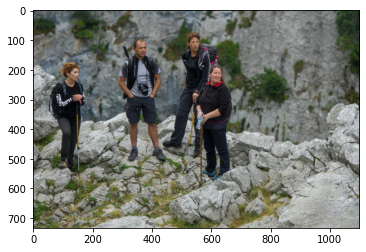

In [9]:
idx = 0
img = imread(df.image_path.iloc[idx])
joints = df.joints.iloc[idx]
plt.imshow(img)

In [10]:
person_ids = np.arange(len(joints), dtype=np.int32)

for pt in joints:
    img = draw_points(img, pt)

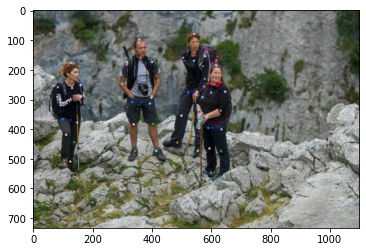

In [11]:
plt.imshow(img)

In [12]:
#skeleton描画のためには、jooints_dictを設定する必要あり
from src.visualize.keypoint_visualization import joints_dict
joints_set = 'mpii'
jdict = joints_dict()[joints_set]

person_ids = np.arange(len(joints), dtype=np.int32)

for i, (pt, pid) in enumerate(zip(joints, person_ids)):
    
    img = draw_points_and_skeleton(img, pt, jdict['skeleton'], person_index=pid,
                                   points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                   points_palette_samples=10, confidence_threshold=0)

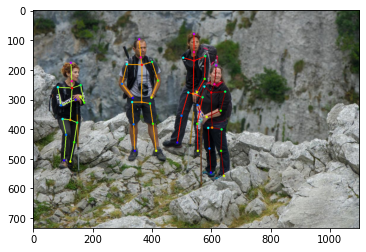

In [13]:
plt.imshow(img)

## Split dataset 

In [17]:
#デモのため、idx=3のみをvalidation(fold=0)に設定。
df['fold'] = 1
df.fold.iloc[3] = 0

/home/magata/.pyenv/versions/3.6.5/envs/basemodel/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
df

,image_path,joints,num_targets,fold
0,/home/magata/tmp/BaseModel/data/demo_keypoint/...,"[[[546.58, 598.66, 1.0], [465.1, 593.3, 1.0], ...",4,1
1,/home/magata/tmp/BaseModel/data/demo_keypoint/...,"[[[405.67, 571.89, 1.0], [288.7, 549.35, 1.0],...",1,1
2,/home/magata/tmp/BaseModel/data/demo_keypoint/...,"[[[559.12, 991.05, 1.0], [260.76, 841.34, 1.0]...",1,1
3,/home/magata/tmp/BaseModel/data/demo_keypoint/...,"[[[696.07, 633.54, 1.0], [536.79, 660.67, 1.0]...",1,0


In [19]:
df.to_pickle('../../data/demo_keypoint/split/demo_trainval.pkl')